In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi64')

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import pyJHTDB
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse

from mpiFFT4py.slab import R2C

In [3]:
%%px

Nx = isotropic1024coarse['nx']; Ny = isotropic1024coarse['ny']; Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']; Ly = isotropic1024coarse['ly']; Lz = isotropic1024coarse['lz']

######################################

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

[stdout:43] 
n_proc = 64
rank = 0


In [4]:
%%px

######################################
#      Computational Domain          #
######################################

nx=Nx//nproc; ny=Ny; nz=Nz
time = 0.0

########## FFT alocation #############

N = np.array([Nx,Ny,Nz],dtype=int)
L = np.array([Lx,Ly,Lz],dtype=float)

FFT = R2C(N, L, MPI.COMM_WORLD, "double", communication='Alltoallw')

######### Vector alocation ###########

In [5]:
%%px

if rank==0:
    print(FFT.real_shape())

[stdout:43] (16, 1024, 1024)


In [6]:
%%px

######### Vector alocation ###########

dx = isotropic1024coarse['dx']

comm.Barrier(); t1=MPI.Wtime()

X = np.zeros(FFT.real_shape(), dtype=FFT.float)
Y = np.zeros(FFT.real_shape(), dtype=FFT.float)
Z = np.zeros(FFT.real_shape(), dtype=FFT.float)

r2 = np.zeros(FFT.real_shape(), dtype=FFT.float)

chi = np.zeros(FFT.real_shape(), dtype=FFT.float)
cchi = np.zeros(FFT.complex_shape(), dtype=FFT.complex)
corr = np.zeros(FFT.real_shape(), dtype=FFT.float)
iCorr = np.zeros(FFT.real_shape(), dtype=FFT.float)

r2Sum = np.zeros(FFT.real_shape(), dtype=FFT.float)
r2F = np.zeros(FFT.real_shape(), dtype=FFT.float)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocating vectors: {0:.2f} seconds\n'.format(t2-t1))

[stdout:43] Alocating vectors: 0.02 seconds


In [7]:
%%px

####### Spatial Information #########

comm.Barrier(); t1=MPI.Wtime()
for i in range(nx):
    if (i+nx*rank)<Nx//2:
        X[i,:,:] = (i+nx*rank)*isotropic1024coarse['dx']
    else:
        X[i,:,:] = isotropic1024coarse['lx']-(i+nx*rank)*isotropic1024coarse['dx']
    
for j in range(ny):
    if j<Ny//2:
        Y[:,j,:] = j*isotropic1024coarse['dy']
    else:
        Y[:,j,:] = isotropic1024coarse['ly']-j*isotropic1024coarse['dy']
    
for k in range(nz):
    if k<Nz//2:
        Z[:,:,k] = k*isotropic1024coarse['dz']
    else:
        Z[:,:,k] = isotropic1024coarse['lz']-k*isotropic1024coarse['dz']
    
r2[:,:,:] = X[:,:,:]**2+Y[:,:,:]**2+Z[:,:,:]**2

r2rt = np.sqrt(r2)
del r2

######## Domain boundaries ##########

minrt = r2rt.min()
maxrt = r2rt.max()

minr2Gl=np.zeros(nproc,dtype=FFT.float)
maxr2Gl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minrt,MPI.DOUBLE],[minr2Gl,MPI.DOUBLE])
comm.Allgather([maxrt,MPI.DOUBLE],[maxr2Gl,MPI.DOUBLE])

minrt = minr2Gl.min()
maxrt = maxr2Gl.max()

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Preparing the real domain for radial integration: {0:.2f} seconds\n'.format(t2-t1))

ner = int((maxrt-minrt)/isotropic1024coarse['dx'])

rbins = np.linspace(minrt,maxrt,ner+1)

[stdout:43] Preparing the real domain for radial integration: 5.36 seconds


In [8]:
%%px

###################################
######## Reading Data #############
###################################

folder = '/home/jhelsas/scratch/slab64'

##########

filename = 'ref-Q-'+str(rank)+'.npz'
file = folder + "/" + filename

comm.Barrier(); t1=MPI.Wtime()
content = np.load(file)
    
Q = np.zeros(FFT.real_shape(), dtype=FFT.float)
Q[:,:,:] = content['Q'].astype(FFT.float)
    
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    print("Finished loading")
    sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

[stdout:43] 
Finished loading
Load from disk: 0.97 seconds


In [9]:
%%px

filename = 'ref-R-'+str(rank)+'.npz'
file = folder + "/" + filename

comm.Barrier(); t1=MPI.Wtime()
content = np.load(file)
    
R = np.zeros(FFT.real_shape(), dtype=FFT.float)
R[:,:,:] = content['R'].astype(FFT.float)
    
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    print("Finished loading")
    sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

#########

[stdout:43] 
Finished loading
Load from disk: 0.95 seconds


In [10]:
%%px

filename = 'ref-strainrate-'+str(rank)+'.npz'
file = folder + "/" + filename

comm.Barrier(); t1=MPI.Wtime()
content = np.load(file)
    
S2 = np.zeros(FFT.real_shape(), dtype=FFT.float)
    
S2[:,:,:] = content['S2'].astype(FFT.float)
    
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    print("Finished loading")
    sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

[stdout:43] 
Finished loading
Load from disk: 0.98 seconds


In [11]:
%%px

#######################################
##### Finding field parameters ########
#######################################

avgE = np.average(S2)
avgEGl=np.zeros(1,dtype=FFT.float)
comm.Allreduce([avgE,MPI.DOUBLE],[avgEGl,MPI.DOUBLE],op=MPI.SUM)
avgE = avgEGl[0]/nproc
if rank == 0:
    print(avgE)
    
avg = avgE

#################################################

minS2 = S2.min(); maxS2 = S2.max()

minS2Gl=np.zeros(nproc,dtype=FFT.float)
maxS2Gl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minS2,MPI.DOUBLE],[minS2Gl,MPI.DOUBLE])
comm.Allgather([maxS2,MPI.DOUBLE],[maxS2Gl,MPI.DOUBLE])

minE = minS2Gl.min(); maxE = maxS2Gl.max()
if rank==0:
    print(minE/avg,maxE/avg)

[stdout:43] 
249.217673008
(3.9848990133269396e-05, 225.01040811291978)


In [12]:
%%px

comm.Barrier()

Q = Q/avg
R = R/(avg**1.5)

In [13]:
%%px

minQ = np.min(Q); maxQ = np.max(Q)

minQGl=np.zeros(nproc,dtype=FFT.float)
maxQGl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minQ,MPI.DOUBLE],[minQGl,MPI.DOUBLE])
comm.Allgather([maxQ,MPI.DOUBLE],[maxQGl,MPI.DOUBLE])

if rank==0:
    print(minQ,maxQ)

minQ = minQGl.min(); maxQ = maxQGl.max()

##########################################

minR = np.min(R); maxR = np.max(R)

minRGl=np.zeros(nproc,dtype=FFT.float)
maxRGl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minR,MPI.DOUBLE],[minRGl,MPI.DOUBLE])
comm.Allgather([maxR,MPI.DOUBLE],[maxRGl,MPI.DOUBLE])

if rank==0:
    print(minR,maxR)
    
minR = minRGl.min(); maxR = maxRGl.max()

if rank==0:
    for k in range(nproc):
        print(round(minQGl[k],5),round(maxQGl[k],5),round(minRGl[k],5),round(maxRGl[k],5))

[stdout:43] 
(-50.068221854326559, 152.6352207374029)
(-264.43272985518973, 216.06563600548628)
(-50.06822, 152.63522, -264.43273, 216.06564)
(-48.29527, 128.52846, -183.22197, 122.66139)
(-54.16208, 131.54312, -177.5528, 151.43402)
(-62.04073, 216.44642, -281.41769, 248.55689)
(-54.61092, 126.63077, -209.11406, 167.55689)
(-42.01515, 142.0222, -252.19177, 174.57901)
(-46.81791, 119.07951, -155.94531, 136.82681)
(-61.41752, 117.16424, -224.67354, 148.17244)
(-65.86876, 148.23972, -363.22765, 202.6231)
(-40.94572, 106.84498, -182.09952, 97.05543)
(-25.94289, 116.71604, -141.30836, 83.65632)
(-26.14684, 112.31097, -88.49053, 90.61654)
(-36.37568, 145.56916, -136.14351, 119.33793)
(-31.53944, 133.09684, -140.5233, 74.17868)
(-62.58017, 137.11928, -258.88186, 187.81968)
(-34.91601, 110.13378, -159.27584, 112.3681)
(-34.79891, 121.90506, -137.24526, 68.2584)
(-30.09933, 85.18046, -98.58675, 75.08447)
(-37.44838, 168.59267, -192.52749, 254.80548)
(-24.83143, 147.91587, -162.43893, 107.8734)


In [14]:
%%px

if rank==0:
    print(minQ,maxQ,minR,maxR)

[stdout:43] (-92.158000139121256, 305.63790387783143, -475.85866702503751, 451.61272029388857)


In [15]:
%%px

comm.Barrier(); t1=MPI.Wtime()

minJ = -0.5; maxJ =  0.5; E_bins = 5
tl = np.linspace(minJ,maxJ,num=E_bins,endpoint=True) 

if rank == 0:
    print("Q and R min/max : ",minQ,maxQ,minR,maxR)

##################################

if rank==0:
    print("Computation Boundaries : ",minJ,maxJ)
    print(tl)
    
lcorr = []; llogr = []; volFr = []

threshold = ((10.0)**3)/((1024.0)**3)

######################################

[stdout:43] 
('Q and R min/max : ', -92.158000139121256, 305.63790387783143, -475.85866702503751, 451.61272029388857)
('Computation Boundaries : ', -0.5, 0.5)
[-0.5  -0.25  0.    0.25  0.5 ]


In [16]:
%%px

comm.Barrier(); t1=MPI.Wtime()

for i in range(E_bins-1):
    comm.Barrier(); istart=MPI.Wtime()
    if(rank==0):
        print("Line - "+str(i))
    
    for j in range(E_bins-1):
        comm.Barrier(); jstart=MPI.Wtime()
                
        tQm = tl[i]; tQM = tl[i+1]; tRm = tl[j]; tRM = tl[j+1]
        Index = (Q>tQm)&(Q<tQM)&(R>tRm)&(R<tRM)
        
        chi[:,:,:] = 0
        chi[Index] = 1
        
        vf = np.average(chi)
        vgl = np.zeros(1,dtype=FFT.float)
        comm.Allreduce([vf,MPI.DOUBLE],[vgl,MPI.DOUBLE],op=MPI.SUM)
        vf = vgl/nproc
                    
        if vf>threshold:
            cchi = FFT.fftn(chi,cchi)
            tmp = cchi*(cchi.conj())
            corr = FFT.ifftn(tmp,corr)
            corr[:,:,:] = corr[:,:,:]/(Nx*Ny*Nz)
                        
            corrLoc,redges = np.histogram(r2rt,bins = rbins,weights=corr)
            r2Loc,r2edges = np.histogram(r2rt,bins = rbins)
            
            corrSum = np.zeros(corrLoc.shape,dtype=corrLoc.dtype)
            comm.Allreduce([corrLoc,MPI.DOUBLE],[corrSum,MPI.DOUBLE],op=MPI.SUM)
            r2Sum = np.zeros(r2Loc.shape,dtype=r2Loc.dtype)
            comm.Allreduce([r2Loc,MPI.DOUBLE],[r2Sum,MPI.DOUBLE],op=MPI.SUM)
        else:
            corrSum = np.zeros(rbins.shape)
            r2Loc = np.ones(rbins.shape)
                        
        if rank==0:
            volFr.append(vf)
            llogr.append(r2Sum)
            lcorr.append(corrSum)
        
        comm.Barrier(); jend=MPI.Wtime()
        if rank==0:
            print("time for iteration: "+str(jend-jstart))
        
    comm.Barrier(); iend=MPI.Wtime()    
    if rank==0:
        print("time to process line: "+str(iend-istart))

comm.Barrier(); t2=MPI.Wtime()

if rank==0:
    print("Total computing time: "+str(t2-t1))

[stdout:43] 
Line - 0
time for iteration: 29.9509439468
time for iteration: 12.1600182056
time for iteration: 12.409992218
time for iteration: 12.4899609089
time to process line: 67.0587520599
Line - 1
time for iteration: 11.889975071
time for iteration: 12.4299750328
time for iteration: 12.6899969578
time for iteration: 12.8400480747
time to process line: 49.9105889797
Line - 2
time for iteration: 12.1689038277
time for iteration: 12.6500279903
time for iteration: 12.4992139339
time for iteration: 12.9800248146
time to process line: 50.3583538532
Line - 3
time for iteration: 12.6507790089
time for iteration: 12.8199961185
time for iteration: 13.3992540836
time for iteration: 13.5107839108
time to process line: 52.4600470066
Total computing time: 219.849426031


[stdout:43] 
t = (-0.3750000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.663
t = (-0.3750000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.883
t = (-0.3750000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.973
t = (-0.3750000,0.3750000)*sigma_2: Linear fit [alpha A] = 2.724
t = (-0.1250000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.724
t = (-0.1250000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.986
t = (-0.1250000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.951
t = (-0.1250000,0.3750000)*sigma_2: Linear fit [alpha A] = 2.730
t = (0.1250000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.786
t = (0.1250000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.957
t = (0.1250000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.965
t = (0.1250000,0.3750000)*sigma_2: Linear fit [alpha A] = 2.753
t = (0.3750000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.844
t = (0.3750000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.985
t = (0.3750000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.977
t = (0.3750

[output:43]

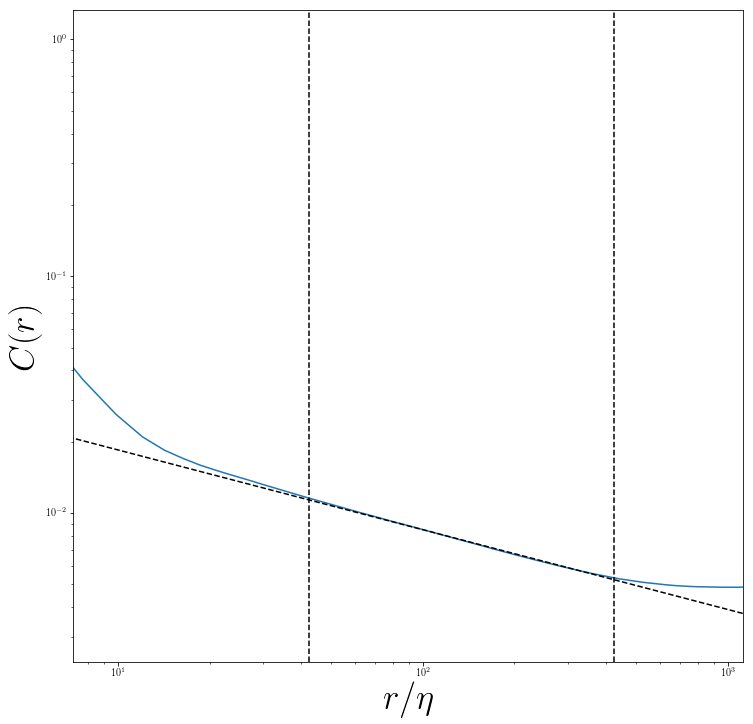

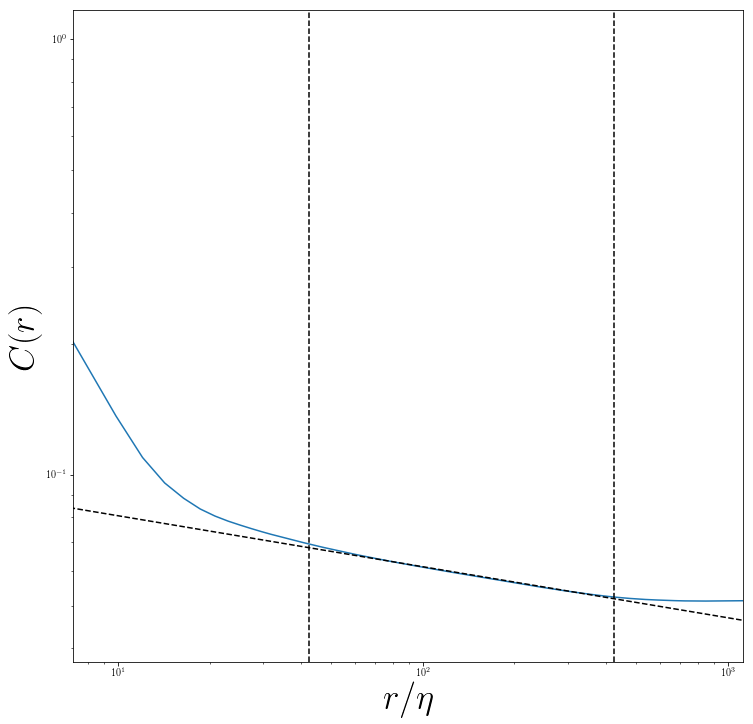

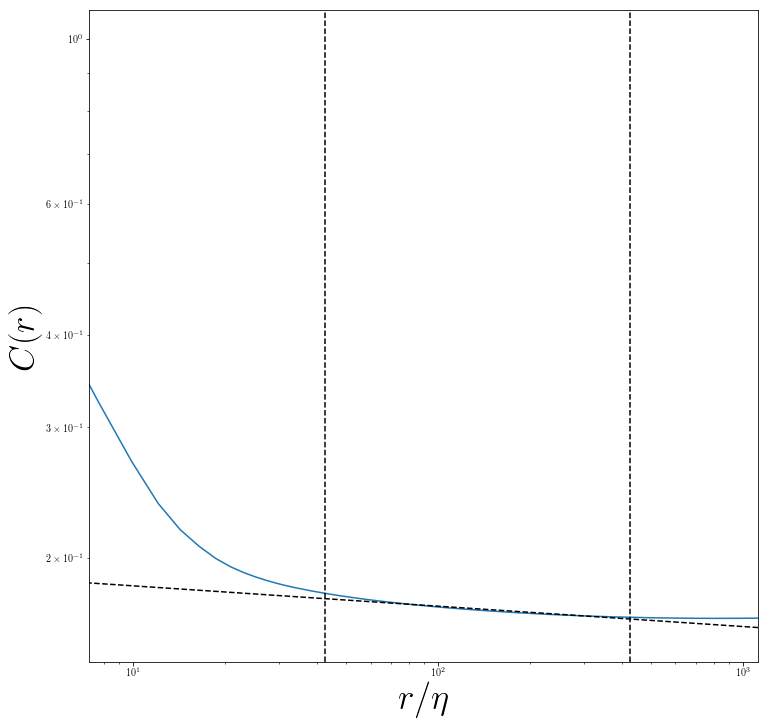

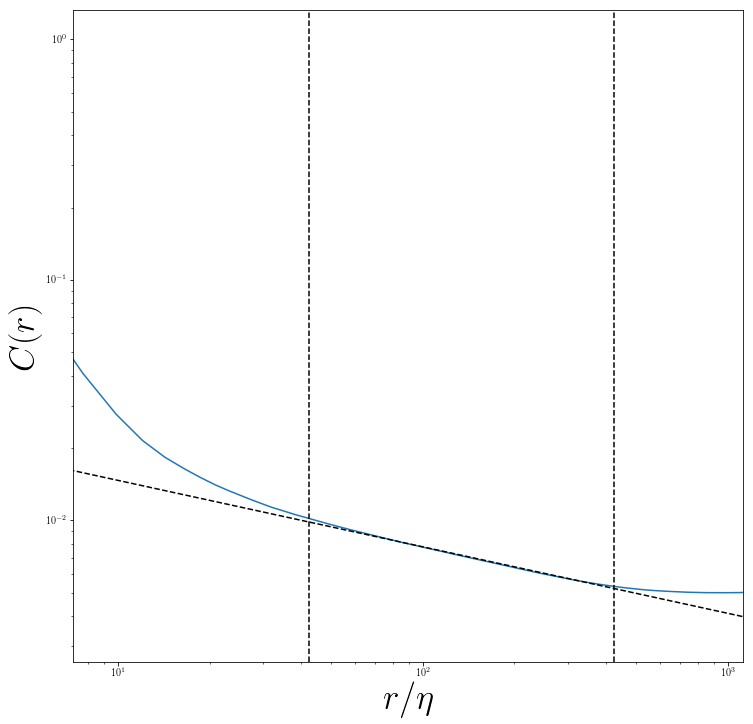

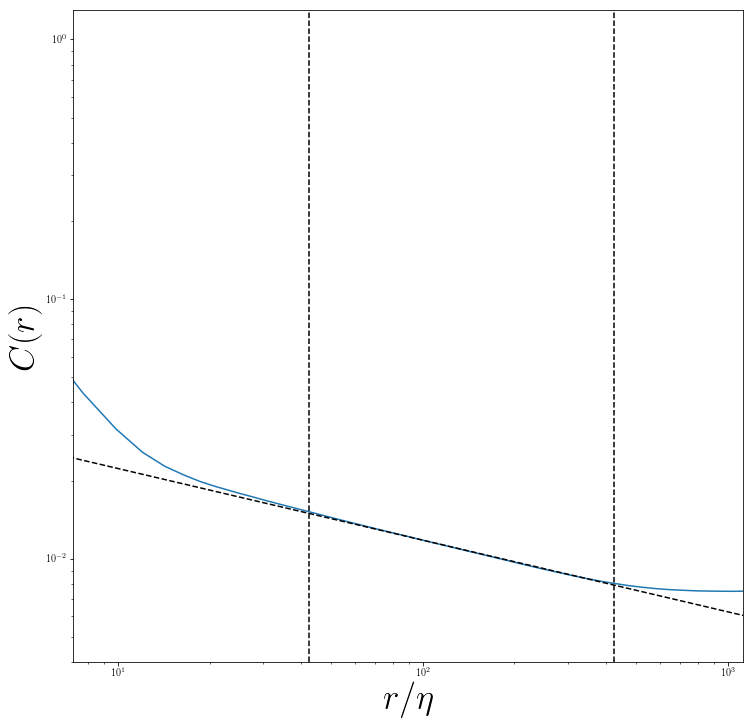

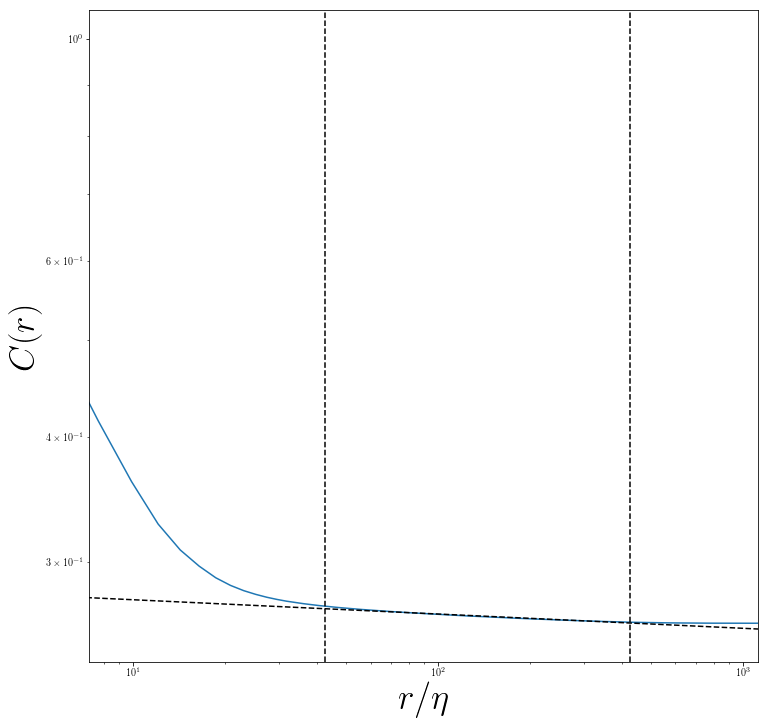

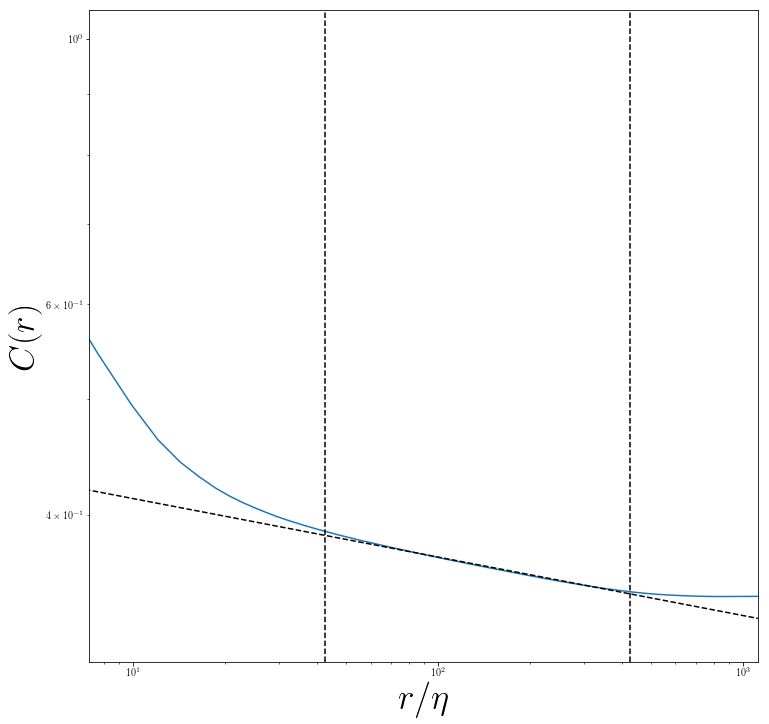

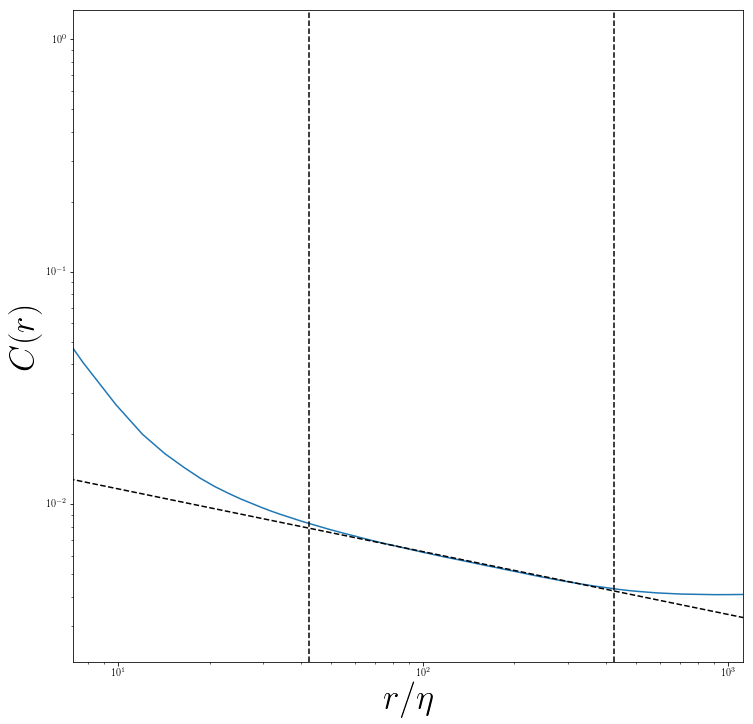

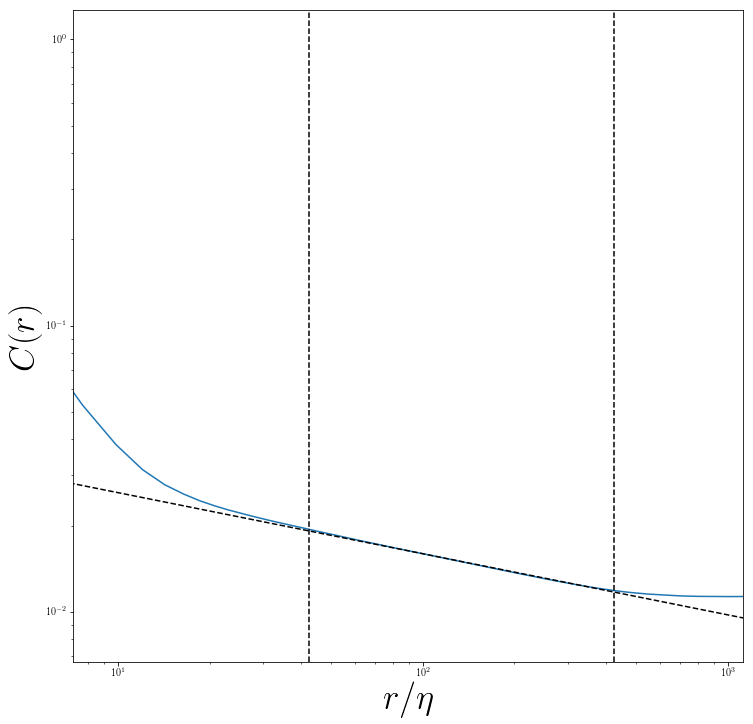

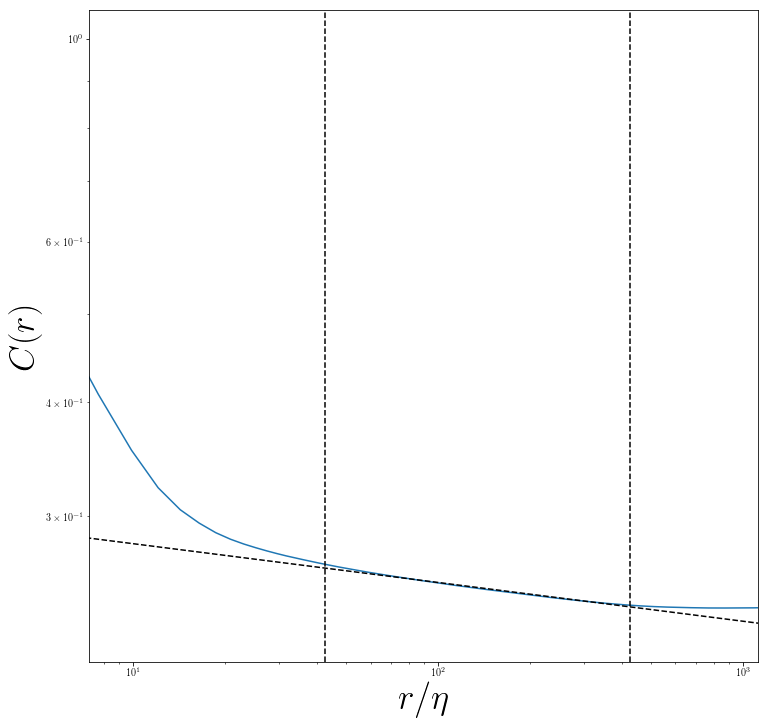

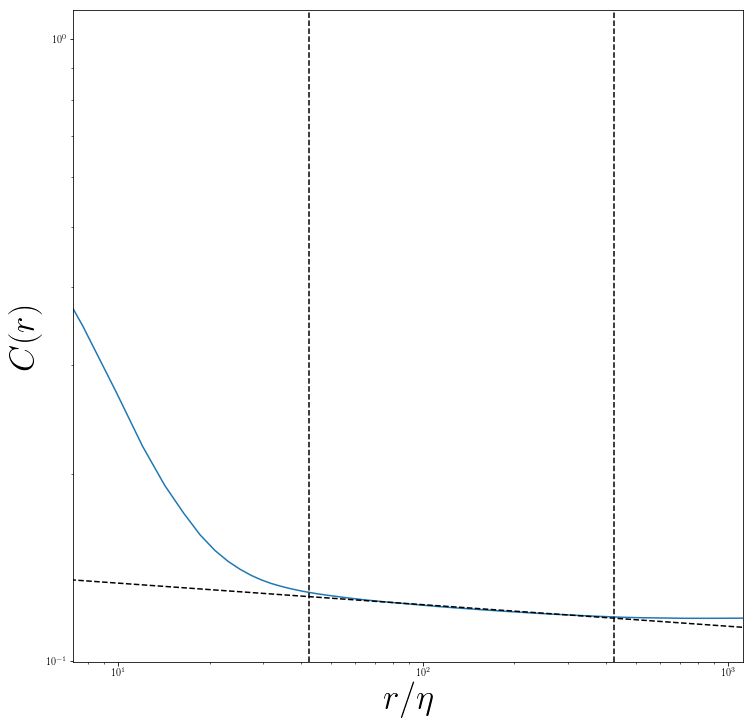

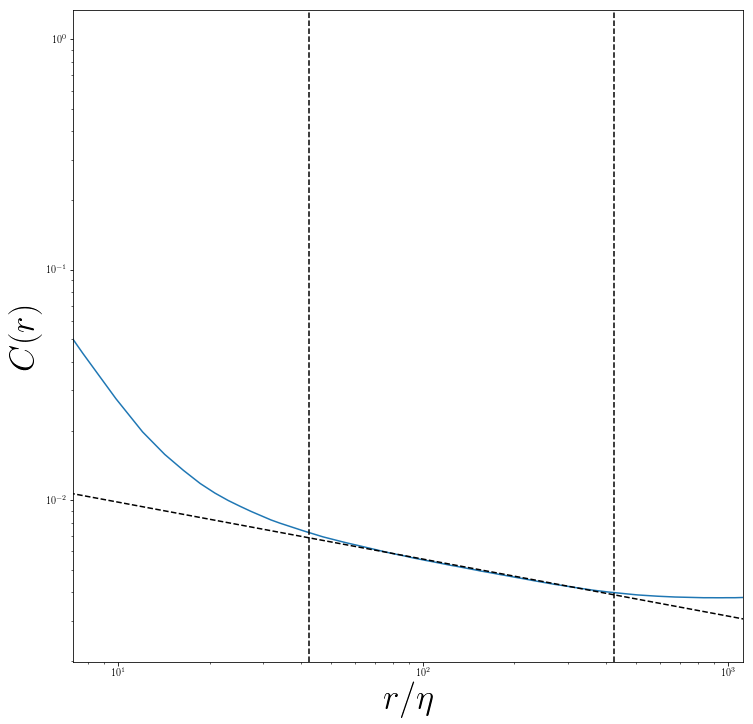

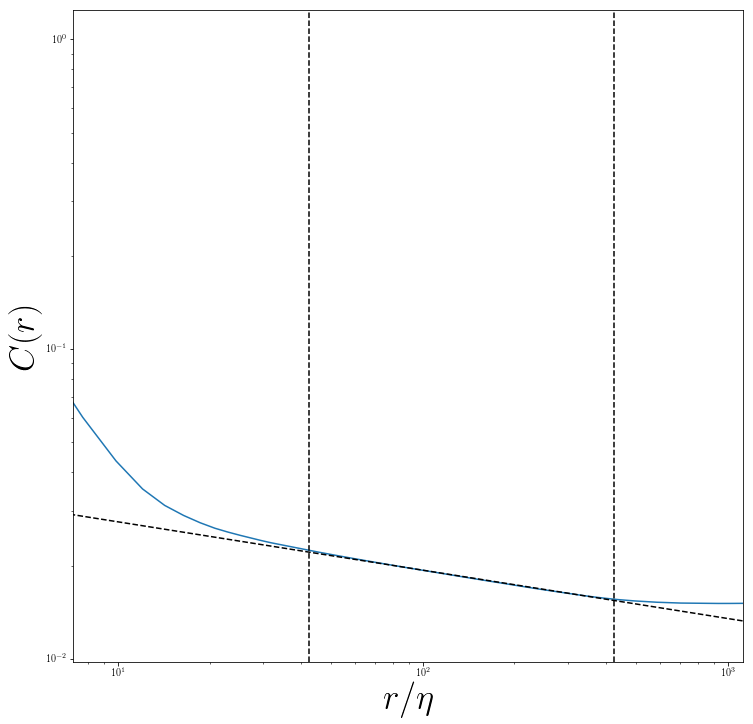

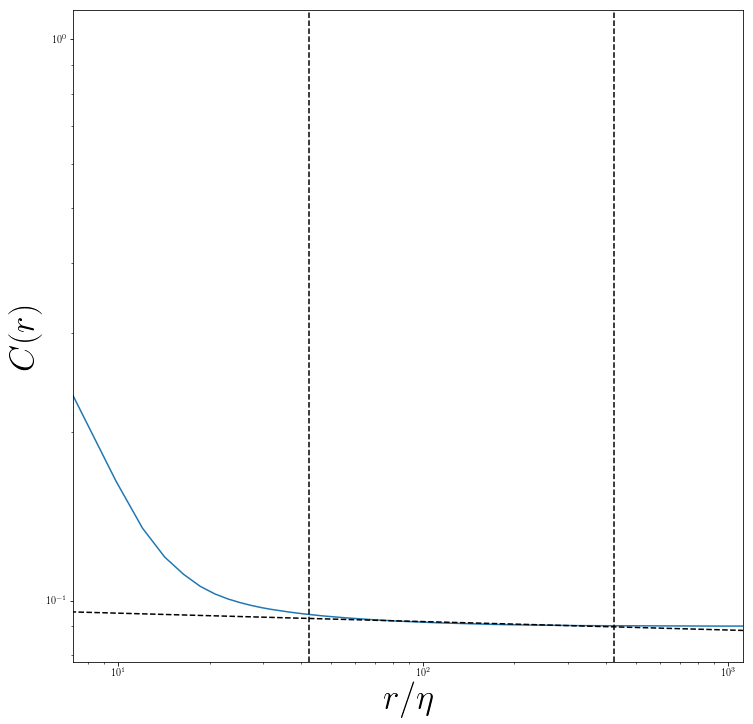

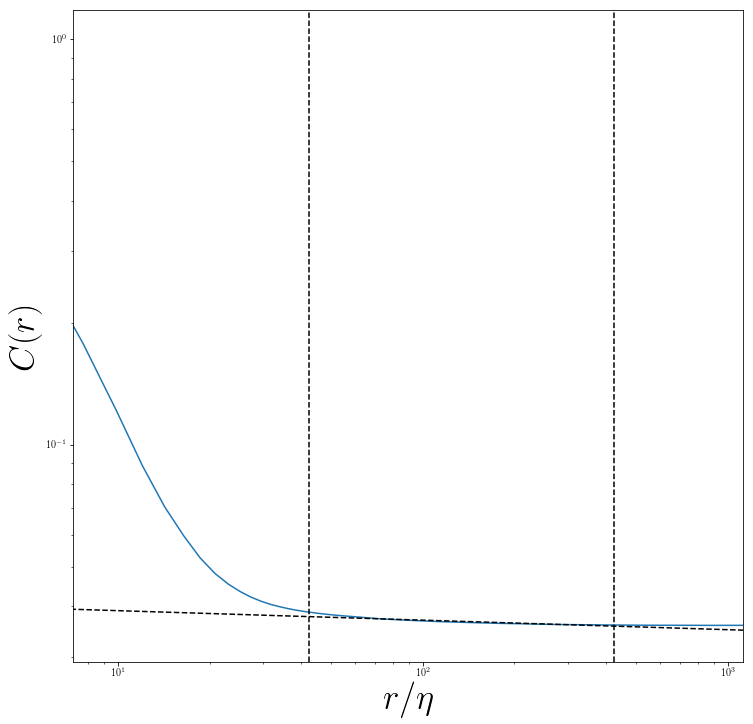

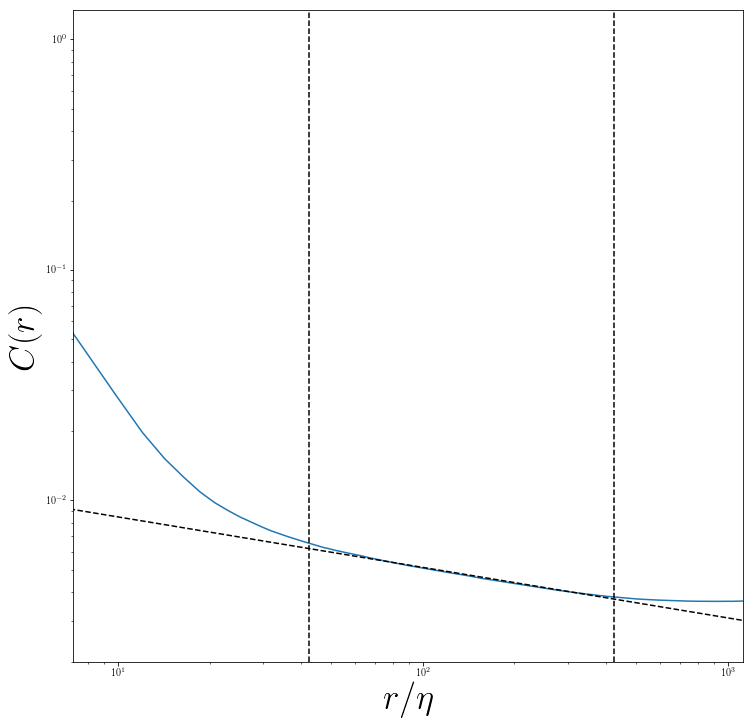

In [17]:
%%px

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('text', usetex=True)

if rank==0:
    eta = 0.00280
    
    rbins = np.linspace(minrt,maxrt,1+ner)    
    bins = (rbins[0:ner]+rbins[1:ner+1])/2
    tempRp = bins[(bins/eta>42.5)&(bins/eta<425)]/eta
    
    fiits = []    
    for i in range(E_bins-1):
        for j in range(E_bins-1):
            tQm = tl[i]; tQM = tl[i+1];            
            tRm = tl[j]; tRM = tl[j+1];
            
            plt.figure(figsize=(12,12))
            plt.xlabel(r'$r/\eta$', fontsize=35)
            plt.ylabel(r'$C(r)$', fontsize=35)
            plt.xlim([20*10**(-3)/eta,np.pi/eta])
            #plt.ylim([10**(-4),10**(0)])
            
            if(volFr[i*(E_bins-1)+j]>threshold):
                tcorr = lcorr[i*(E_bins-1)+j][llogr[i*(E_bins-1)+j]>0]
                tlogr = llogr[i*(E_bins-1)+j][llogr[i*(E_bins-1)+j]>0]
                tbins = bins[llogr[i*(E_bins-1)+j]>0]
                
                corrF = tcorr/tlogr
                tempCorrF = corrF[(tbins/eta>42.5)&(tbins/eta<425)]
                idx = (tempCorrF>0)
                
                if(len(tempCorrF[idx])>0):
                    fit = np.polyfit(np.log(tempRp[idx]),np.log(tempCorrF[idx]/corrF[0]),1)
                else:
                    fit = np.array([-4,0])
                    
                plt.loglog(bins/eta,corrF/corrF[0])
                plt.loglog(bins/eta,np.exp(fit[1])*((bins/eta)**(fit[0])),'k--')
            else:
                fit = np.array([-4,0])
                
            plt.axvline(x=42.50, color='k', linestyle='--')
            plt.axvline(x=425.0, color='k', linestyle='--')
            fiits.append(fit[0])
            print('t = ({one:.7f},{two:.7f})*sigma_2: Linear fit [alpha A] = {tree:.3f}'.format(one=(tQm+tQM)/2,two=(tRm+tRM)/2,tree=fit[0]+3))
            
    fiits = np.array(fiits)

In [32]:
%%px

E_bins = 6
dt = 0.2
tlr = [0.0, 1.0, 3.0, 6.0,-1.0,-1.0]
tlq = [0.0,-1.0,-3.0,-6.0, 1.0,-1.0]

In [33]:
%%px

lcorr = []; llogr = []; volFr = []

comm.Barrier(); t1=MPI.Wtime()

for i in range(E_bins):
    comm.Barrier(); istart=MPI.Wtime()
    if(rank==0):
        print("Line - "+str(i))
        
    tQm = tlq[i]-dt/2; tQM = tlq[i]+dt/2
    tRm = tlr[i]-dt/2; tRM = tlr[i]+dt/2
    Index = (Q>tQm)&(Q<tQM)&(R>tRm)&(R<tRM)
    
    chi[:,:,:] = 0
    chi[Index] = 1
    
    vf = np.average(chi)
    vgl = np.zeros(1,dtype=FFT.float)
    comm.Allreduce([vf,MPI.DOUBLE],[vgl,MPI.DOUBLE],op=MPI.SUM)
    vf = vgl/nproc
    
    if vf>threshold:
        cchi = FFT.fftn(chi,cchi)
        tmp = cchi*(cchi.conj())
        corr = FFT.ifftn(tmp,corr)
        corr[:,:,:] = corr[:,:,:]/(Nx*Ny*Nz)
        
        corrLoc,redges = np.histogram(r2rt,bins = rbins,weights=corr)
        r2Loc,r2edges = np.histogram(r2rt,bins = rbins)
        
        corrSum = np.zeros(corrLoc.shape,dtype=corrLoc.dtype)
        comm.Allreduce([corrLoc,MPI.DOUBLE],[corrSum,MPI.DOUBLE],op=MPI.SUM)
        r2Sum = np.zeros(r2Loc.shape,dtype=r2Loc.dtype)
        comm.Allreduce([r2Loc,MPI.DOUBLE],[r2Sum,MPI.DOUBLE],op=MPI.SUM)
    else:
        corrSum = np.zeros(rbins.shape)
        r2Loc = np.ones(rbins.shape)
        
    if rank==0:
        volFr.append(vf)
        llogr.append(r2Sum)
        lcorr.append(corrSum)
        
    comm.Barrier(); iend=MPI.Wtime()    
    if rank==0:
        print("time to process line: "+str(iend-istart))
        
comm.Barrier(); t2=MPI.Wtime()

if rank==0:
    print("Total computing time: "+str(t2-t1))

[stdout:43] 
Line - 0
time to process line: 13.048167944
Line - 1
time to process line: 13.0800819397
Line - 2
time to process line: 13.8199131489
Line - 3
time to process line: 13.2407488823
Line - 4
time to process line: 13.3907220364
Line - 5
time to process line: 13.1597568989
Total computing time: 79.8550720215


[stdout:43] 
t = (0.0000000,0.0000000)*sigma_2: Linear fit [alpha A] = 2.916
t = (-1.0000000,1.0000000)*sigma_2: Linear fit [alpha A] = 2.481
t = (-3.0000000,3.0000000)*sigma_2: Linear fit [alpha A] = 2.173
t = (-6.0000000,6.0000000)*sigma_2: Linear fit [alpha A] = 2.054
t = (1.0000000,-1.0000000)*sigma_2: Linear fit [alpha A] = 2.674
t = (-1.0000000,-1.0000000)*sigma_2: Linear fit [alpha A] = 2.350


[output:43]

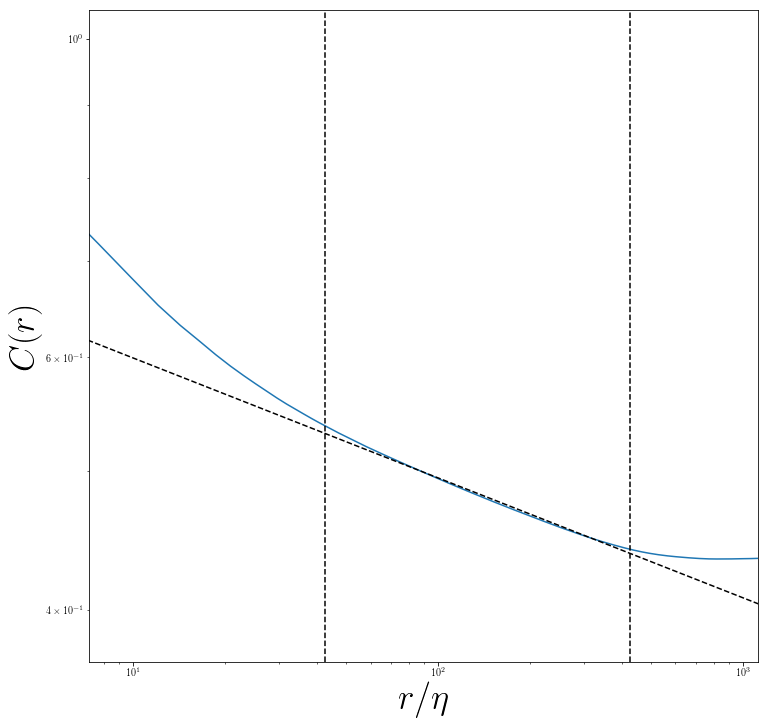

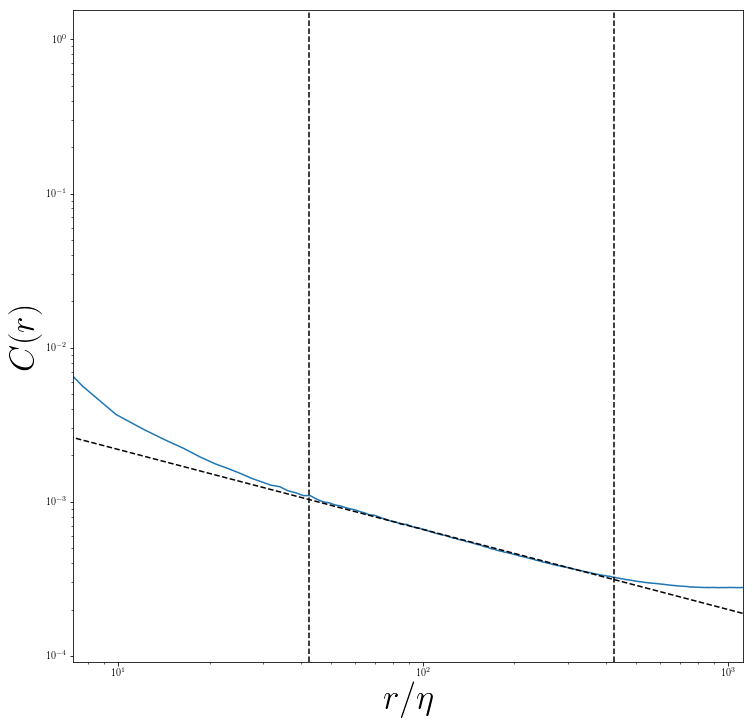

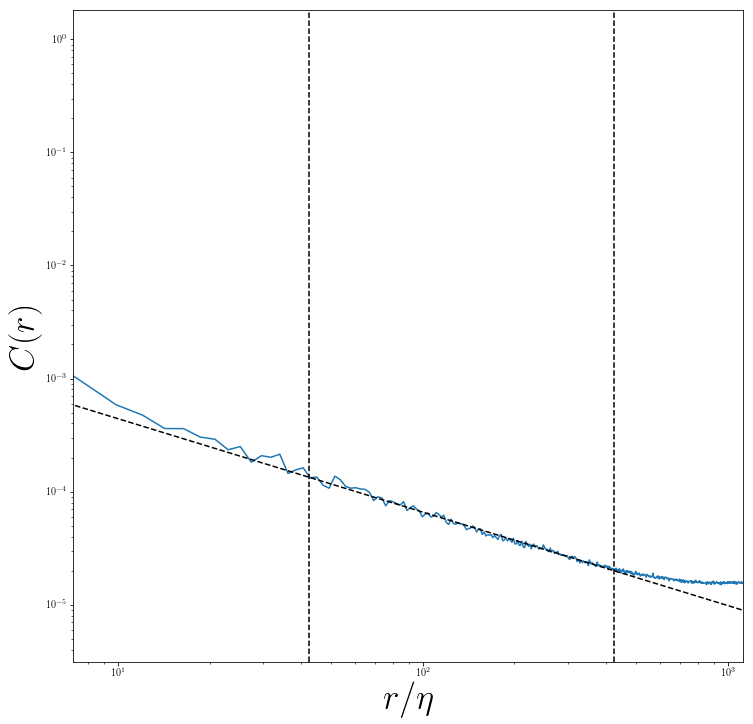

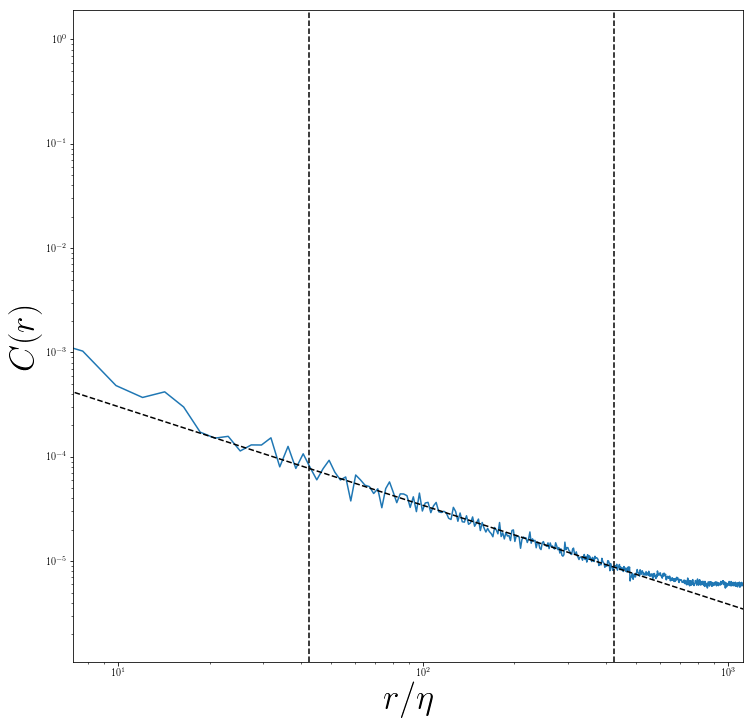

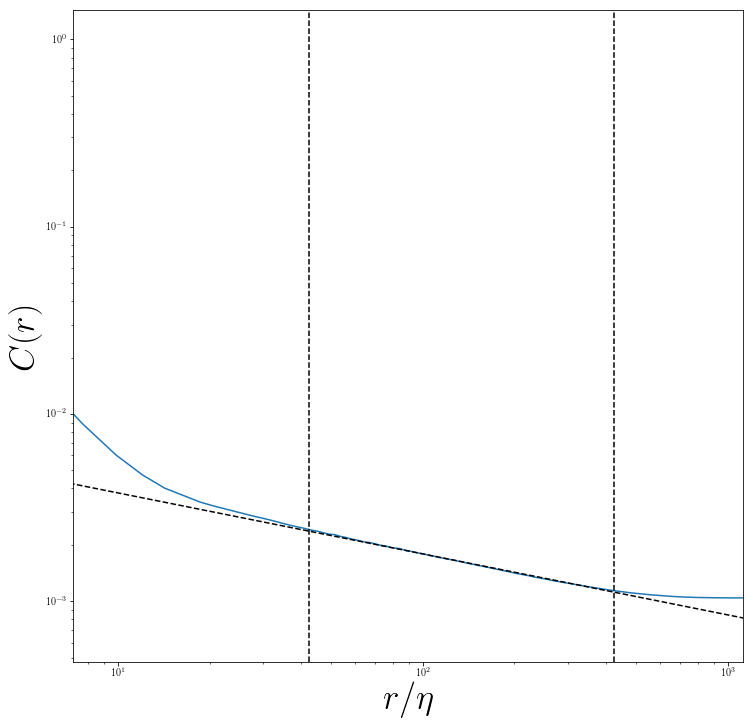

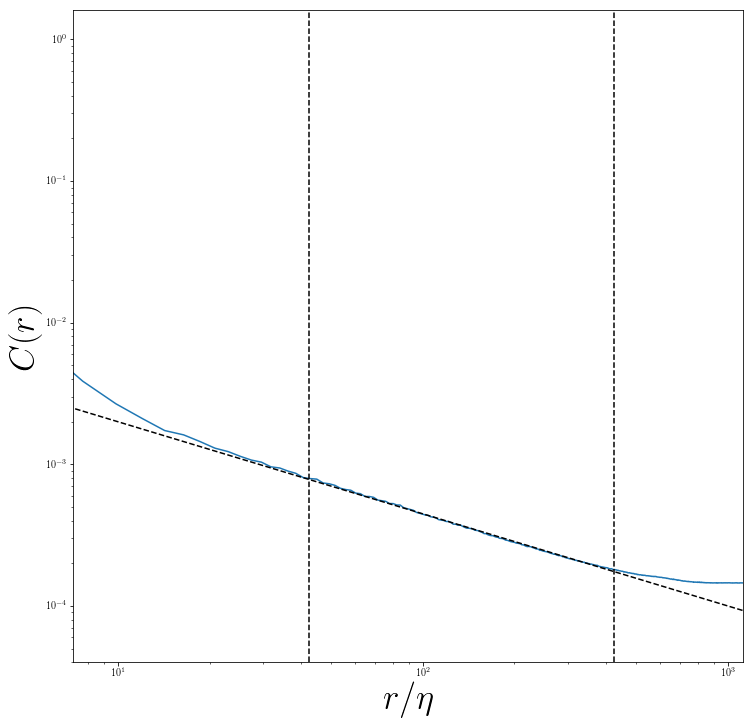

In [34]:
%%px

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('text', usetex=True)

if rank==0:
    eta = 0.00280
    
    rbins = np.linspace(minrt,maxrt,1+ner)    
    bins = (rbins[0:ner]+rbins[1:ner+1])/2
    tempRp = bins[(bins/eta>42.5)&(bins/eta<425)]/eta
    
    fiits = []    
    for i in range(E_bins):
        tQm = tlq[i]-dt/2; tQM = tlq[i]+dt/2
        tRm = tlr[i]-dt/2; tRM = tlr[i]+dt/2
        
        plt.figure(figsize=(12,12))
        plt.xlabel(r'$r/\eta$', fontsize=35)
        plt.ylabel(r'$C(r)$', fontsize=35)
        plt.xlim([20*10**(-3)/eta,np.pi/eta])
        #plt.ylim([10**(-4),10**(0)])
        
        if(volFr[i]>threshold):
            tcorr = lcorr[i][llogr[i]>0]
            tlogr = llogr[i][llogr[i]>0]
            tbins = bins[llogr[i]>0]
            
            corrF = tcorr/tlogr
            tempCorrF = corrF[(tbins/eta>42.5)&(tbins/eta<425)]
            idx = (tempCorrF>0)
            
            if(len(tempCorrF[idx])>0):
                fit = np.polyfit(np.log(tempRp[idx]),np.log(tempCorrF[idx]/corrF[0]),1)
            else:
                fit = np.array([-4,0])
                
            plt.loglog(bins/eta,corrF/corrF[0])
            plt.loglog(bins/eta,np.exp(fit[1])*((bins/eta)**(fit[0])),'k--')
        else:
            fit = np.array([-4,0])
            
        plt.axvline(x=42.50, color='k', linestyle='--')
        plt.axvline(x=425.0, color='k', linestyle='--')
        fiits.append(fit[0])
        print('t = ({one:.7f},{two:.7f})*sigma_2: Linear fit [alpha A] = {tree:.3f}'.format(one=(tQm+tQM)/2,two=(tRm+tRM)/2,tree=fit[0]+3))
            
    fiits = np.array(fiits)